In [1]:
import pickle
import torch
import torch.nn as nn
import matplotlib.pyplot as plt

# heatmap visualization
import sys

import pickle
import re
import os
sys.path.append("..")

import random
import numpy as np
import torch
from random import shuffle
import argparse
import pickle

import collections

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from model.QACGBERT import *

from sklearn.metrics import f1_score, accuracy_score, roc_auc_score

from torch.utils.data import DataLoader, TensorDataset
from torch.utils.data.distributed import DistributedSampler
from torch.utils.data.sampler import RandomSampler, SequentialSampler
from tqdm import tqdm, trange

from util.optimization import BERTAdam
from util.processor import (Sentihood_NLI_M_Processor,
                            Semeval_NLI_M_Processor)

from util.tokenization import *

from util.evaluation import *

from util.processor import *
from run_classifier import *
from util.train_helper import *

import seaborn as sns; sns.set()

import matplotlib.pyplot as plt
plt.rcParams["font.family"] = "Times New Roman"

#### Set-ups

In [3]:
# Note that this notebook only supports single GPU evaluation
# which is sufficient for most of tasks by using lower batch size.
IS_CUDA = False
if IS_CUDA:
    CUDA_DEVICE = "cuda:2"
    device = torch.device(CUDA_DEVICE)
    n_gpu = torch.cuda.device_count()
    logger.info("device %s in total n_gpu %d distributed training", device, n_gpu)
else:
    # bad luck, we are on CPU now!
    logger.info("gpu is out of the picture, let us use CPU")
    device = torch.device("cpu")
    
model, optimizer, tokenizer = \
    getModelOptimizerTokenizer("QACGBERT", 
                               vocab_file="../model/uncased_L-12_H-768_A-12/vocab.txt",
                               bert_config_file="../model/uncased_L-12_H-768_A-12/bert_config.json",
                               init_checkpoint="../../results/sentihood/QACGBERT-reproduce/best_checkpoint.bin",
                               label_list=['None', 'Positive', 'Negative'],
                               num_train_steps=1,
                               learning_rate=2e-5,
                               base_learning_rate=2e-5,
                               warmup_proportion=0.1,
                               init_lrp=True)
import argparse
args = argparse.ArgumentParser()
args.task_name = "sentihood_NLI_M"
vocab_data_dir = "../model/uncased_L-12_H-768_A-12/vocab.txt"

def heatmap_viz(token_grad, vmin=0, vmax=1, cmap="Blues"):
    scores = [tu[1] for tu in token_grad]
    tokens = [tu[0] for tu in token_grad]
    fig, ax = plt.subplots(figsize=(15,1))
    ax = sns.heatmap([scores], cmap=cmap, xticklabels=tokens, yticklabels=False,
                     cbar_kws=dict(shrink=1, aspect=4, ), linewidths=0.8)
    ax.set_xticklabels(tokens, size = 18)
    cbar = ax.collections[0].colorbar
    # here set the labelsize by 20
    cbar.ax.tick_params(labelsize=20)
    plt.show()
    
def inverse_mapping(vocab_dict):
    inverse_vocab_dict = {}
    for k, v in vocab_dict.items():
        inverse_vocab_dict[v] = k
    return inverse_vocab_dict

def translate(token_ids, vocab):
    tokens = []
    for _id in token_ids.tolist():
        tokens.append(vocab[_id])
    return tokens

vocab = inverse_mapping(load_vocab(vocab_data_dir, pretrain=False))

context_id_map_sentihood = ['location - 1 - general',
                            'location - 1 - price',
                            'location - 1 - safety',
                            'location - 1 - transit location',
                            'location - 2 - general',
                            'location - 2 - price',
                            'location - 2 - safety',
                            'location - 2 - transit location']

02/22/2022 22:16:04 - INFO - util.train_helper -   gpu is out of the picture, let us use CPU
02/22/2022 22:16:04 - INFO - util.train_helper -   *** Model Config ***
02/22/2022 22:16:04 - INFO - util.train_helper -   {
  "attention_probs_dropout_prob": 0.1,
  "full_pooler": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "max_position_embeddings": 512,
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "type_vocab_size": 2,
  "vocab_size": 30522
}

02/22/2022 22:16:04 - INFO - util.train_helper -   model = QACGBERT


init_weight = True


02/22/2022 22:16:06 - INFO - util.train_helper -   retraining with saved model.
02/22/2022 22:16:06 - INFO - util.train_helper -   loading a best checkpoint, not BERT pretrain.


init_lrp = True


In [4]:
test_examples = Sentihood_NLI_M_Processor().get_test_examples("../../datasets/sentihood")
test_features = convert_examples_to_features(
    test_examples, ['None', 'Positive', 'Negative'], 512,
    tokenizer, 1, True, args=args)

all_input_ids = torch.tensor([f.input_ids for f in test_features], dtype=torch.long)
all_input_mask = torch.tensor([f.input_mask for f in test_features], dtype=torch.long)
all_segment_ids = torch.tensor([f.segment_ids for f in test_features], dtype=torch.long)
all_label_ids = torch.tensor([f.label_id for f in test_features], dtype=torch.long)
all_seq_len = torch.tensor([[f.seq_len] for f in test_features], dtype=torch.long)
all_context_ids = torch.tensor([f.context_ids for f in test_features], dtype=torch.long)

test_data = TensorDataset(all_input_ids, all_input_mask, all_segment_ids,
                            all_label_ids, all_seq_len, all_context_ids)
test_sampler = RandomSampler(test_data)
test_dataloader = DataLoader(test_data, batch_size=1, sampler=test_sampler)

100%|██████████| 7516/7516 [00:02<00:00, 3688.75it/s]


#### Single Sample Visualizations

In [5]:
model.eval()
rand_sampler = torch.utils.data.RandomSampler(test_data, num_samples=1, replacement=True)
train_sampler = torch.utils.data.DataLoader(test_data, batch_size=1, sampler=rand_sampler)

for input_ids, input_mask, segment_ids, label_ids, seq_lens, context_ids in train_sampler:
    max_seq_lens = max(seq_lens)[0]
    input_ids = input_ids[:,:max_seq_lens]
    input_mask = input_mask[:,:max_seq_lens]
    segment_ids = segment_ids[:,:max_seq_lens]
    tmp_test_loss, logits, all_new_attention_probs, all_attention_probs, all_quasi_attention_prob, _ = \
        model(input_ids, segment_ids, input_mask, seq_lens,
                device=torch.device("cpu"), labels=label_ids,
                context_ids=context_ids)

    # backing out using gradients
    logits = F.softmax(logits, dim=-1)
    sensitivity_class = 1
    sensitivity_scores = torch.zeros(logits.shape)
    sensitivity_scores[:,sensitivity_class] = 1.0
    sensitivity_scores = model.backward_gradient(sensitivity_scores)
    sensitivity_scores_norm = torch.norm(sensitivity_scores, dim=-1) * torch.norm(sensitivity_scores, dim=-1)
    max_sensitivity_scores_norm = torch.max(sensitivity_scores_norm)
    sensitivity_scores_norm = sensitivity_scores_norm / max_sensitivity_scores_norm
    sensitivity_scores_norm = sensitivity_scores_norm.squeeze(dim=0).tolist()
    print("*** pred logits ***")
    print(logits)
    print("*** true label ***")
    print(label_ids[0])

*** pred logits ***
tensor([[0.3926, 0.3218, 0.2857]], grad_fn=<SoftmaxBackward0>)
*** true label ***
tensor(0)


*** context ***
location - 1 - price
*** gradient plots ***


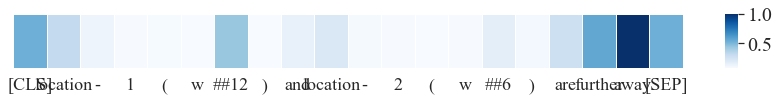

*** a_h plots ***


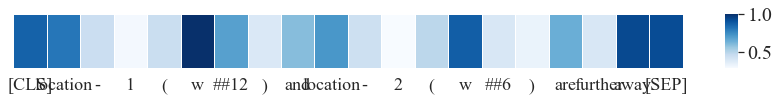

*** a_quasi plots ***


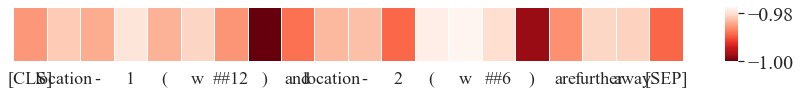

In [6]:
print("*** context ***")
print(context_id_map_sentihood[context_ids[0]])
tokens = translate(input_ids[0], vocab)
# hacky way to pick a head at random
print("*** gradient plots ***")
heatmap_viz(list(zip(tokens, sensitivity_scores_norm)), cmap="Blues", vmin=0, vmax=1)

l = 0
h = random.randint(0, 11)
print("*** a_h plots ***")
a_h = all_new_attention_probs[l].squeeze(dim=0)[h].sum(dim=0).data
a_h = a_h / torch.max(torch.abs(a_h))
heatmap_viz(list(zip(tokens, a_h)), cmap="Blues", vmin=-0.5, vmax=0.5)

# print("*** a_self plots ***")
# a_self = all_attention_probs[l].squeeze(dim=0)[h].sum(dim=0).data
# a_self = a_self / torch.max(torch.abs(a_self))
# heatmap_viz(list(zip(tokens, a_self)), cmap="Blues", vmin=0, vmax=1)

print("*** a_quasi plots ***")
a_quasi = all_quasi_attention_prob[l].squeeze(dim=0)[h].sum(dim=0).data
a_quasi = (a_quasi / torch.max(torch.abs(a_quasi)))
heatmap_viz(list(zip(tokens, a_quasi)), cmap="Reds_r", vmin=-0.5, vmax=0.5)

#### Histgrams of Weight Matrices

In [7]:
model.eval()
rand_sampler = torch.utils.data.RandomSampler(test_data, num_samples=5000, replacement=True)
train_sampler = torch.utils.data.DataLoader(test_data, batch_size=1, sampler=rand_sampler)

samples_lambda_context = []
attention_probs = []
quasi_attention_scores = []
new_attention_probs = []
count = 0

for input_ids, input_mask, segment_ids, label_ids, seq_lens, context_ids in train_sampler:
    max_seq_lens = max(seq_lens)[0]
    input_ids = input_ids[:,:max_seq_lens]
    input_mask = input_mask[:,:max_seq_lens]
    segment_ids = segment_ids[:,:max_seq_lens]
    tmp_test_loss, logits, all_new_attention_probs, all_attention_probs, all_quasi_attention_prob, all_lambda_context = \
        model(input_ids, segment_ids, input_mask, seq_lens,
                device=torch.device("cpu"), labels=label_ids,
                context_ids=context_ids)
    if label_ids.tolist()[0] != 0:
        for i in range(12):
            samples_lambda_context.extend(all_lambda_context[i].flatten().tolist())
            attention_probs.extend(all_attention_probs[i].flatten().tolist())
            quasi_attention_scores.extend(all_quasi_attention_prob[i].flatten().tolist())
            new_attention_probs.extend(all_new_attention_probs[i].flatten().tolist())
        count += 1
        if count == 200:
            break
    

In [8]:
def plot_histgram(array_in,  facecolor='g', xl=-1, xh=1):
    import matplotlib as mpl
    mpl.style.use("default")
    font = {'family' : 'Times New Roman',
            'size'   : 30}
    plt.rc('font', **font)
    
    fig = plt.figure(figsize=(6,6))
    ax = fig.add_subplot(111)
    g = ax.hist(array_in, bins=50, facecolor=facecolor)
    plt.grid(True)
    plt.grid(color='black', linestyle='-.')
    import matplotlib.ticker as mtick
    ax.yaxis.set_major_formatter(mtick.FormatStrFormatter('%.2e'))
    ax.set_yscale('log')
    plt.tight_layout()
    plt.xlim(xl, xh)
    plt.xticks([-1.5, -0.75, 0, 0.75, 1.5], ["-1.5", "-0.75", "0.0", "0.75", "1.5"], fontsize=30)
    # plt.xticks([-0.5, -0.25, 0, 0.25, 0.5], ["-0.50", "-0.25", "0.0", "0.25", "0.5"], fontsize=30)
    # plt.xticks([0, 0.25, 0.5, 0.75, 1], ["0.0", "0.25", "0.50", "0.75", "1.0"], fontsize=20)
    # plt.xticks([0, 0.25, 0.5, 0.75, 1], ["0.0", "0.25", "0.50", "0.75", "1.0"], fontsize=20)
    plt.show()

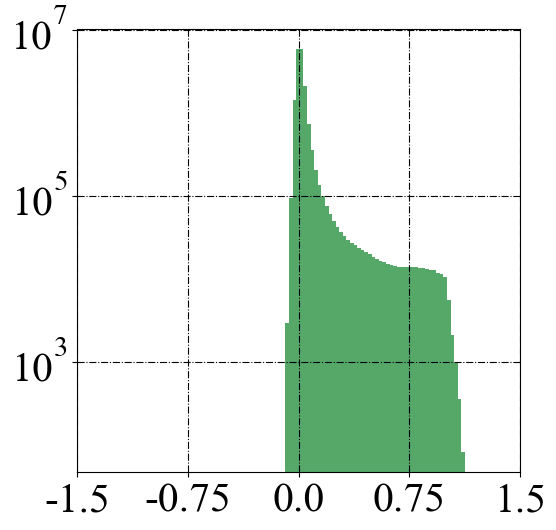

In [9]:
plot_histgram(new_attention_probs, facecolor="g", xl=-1, xh=1)